In [1]:
# Applications of Machine Learning in Remote Sensing
# Homework 5 - Problem 2

# import files and mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Problem 2.a: Using a Pretrained Model as a Feature Extractor

Number of classes: 21


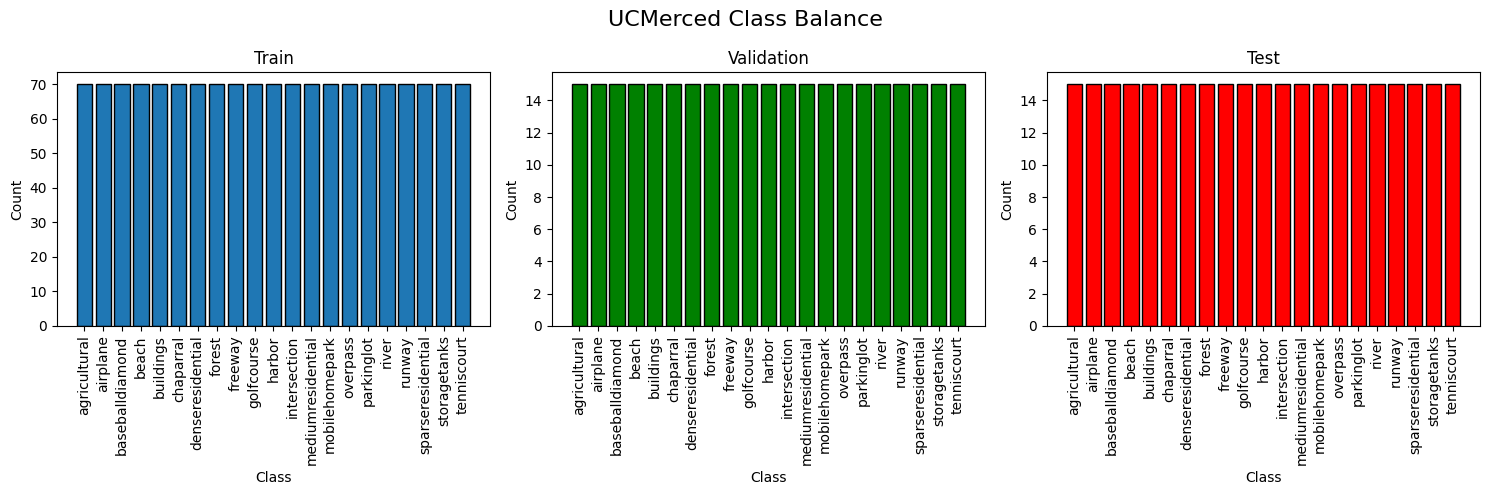

In [2]:
# Normalize all images using the standard ImageNet statistics
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


# Convert images to tensors and normalize the mean and std to standard ImageNet stats
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (required for ResNet)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Assign the image folder and apply the transforms
dataset = ImageFolder(root='/content/drive/MyDrive/Imaging Science MS/Applied ML for Remote Sensing/Homework/HW5 - Neural Networks/Problem 2/UCMerced_LandUse/Images',
                      transform=transform)

# Class labels per sample
classes = np.array(dataset.targets)
num_classes = len(np.unique(classes))
print(f"Number of classes: {num_classes}")

# Split into train and temp datasets (70% training / 15% validation / 15% testing)
train_idx, temp_idx = train_test_split(
    np.arange(len(classes)),
    train_size=0.7,
    stratify=classes,
    random_state=15 # fix seed for deterministic split
)

# Split temp into validation and test sets
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=classes[temp_idx],
    random_state=15 # fix seed for deterministic split
)

# Create the subsets for each division (instantiate datasets)
train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)

# Crate dataloaders for each division
batch_size = 64
num_workers = 2
prefetch_factor = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True,prefetch_factor=prefetch_factor)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True,prefetch_factor=prefetch_factor)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True,prefetch_factor=prefetch_factor)

#----------- Plot histograms to show class balance between datasets ------------

# Extract class labels for each split
train_labels = classes[train_idx]
val_labels   = classes[val_idx]
test_labels  = classes[test_idx]

# Access class names
class_names = dataset.classes

fig,ax = plt.subplots(1,3,figsize=(15,5))
# Train histogram
ax[0].bar(range(len(class_names)), np.bincount(train_labels), edgecolor='black')
ax[0].set_title('Train')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')
ax[0].set_xticks(range(len(class_names)))
ax[0].set_xticklabels(class_names, rotation=90)

# Validation histogram
ax[1].bar(range(len(class_names)), np.bincount(val_labels), color='g', edgecolor='black')
ax[1].set_title('Validation')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')
ax[1].set_xticks(range(len(class_names)))
ax[1].set_xticklabels(class_names, rotation=90)

# Test histogram
ax[2].bar(range(len(class_names)), np.bincount(test_labels), color='r', edgecolor='black')
ax[2].set_title('Test')
ax[2].set_xlabel('Class')
ax[2].set_ylabel('Count')
ax[2].set_xticks(range(len(class_names)))
ax[2].set_xticklabels(class_names, rotation=90)

plt.suptitle('UCMerced Class Balance', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Using a Pretrained Model for Feature Extraction
import torchvision.models as models
import torch.nn as nn
import torch

# Import a ResNet18 model with ImageNet pretrained weights
resnet18 = models.resnet18(pretrained=True)

# Remove the final classification head of the model
model = nn.Sequential(*list(resnet18.children())[:-1]) # assign new model all layers except the last

# Change runtime type to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using:", device)
model.eval()

def resnet_feature_extract(dataloader):

  all_features = []
  all_labels = []

  with torch.no_grad():  # Don't track gradients
    for X_batch, y_batch in dataloader:

        # Send input images and classes to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Get the feature vector for the batch
        features = model(X_batch)  # Forward pass

        # Flatten the features
        features = features.view(features.size(0), -1)  # Flatten to [batch_size, 512]

        # Store the features and labels
        all_features.append(features.cpu())  # Move to CPU for easier handling
        all_labels.append(y_batch.cpu())  # Move to CPU for easier handling

  # Concatenate
  all_features = torch.cat(all_features, dim=0)
  all_labels = torch.cat(all_labels, dim=0)
  return all_features, all_labels


In [ ]:
#------------- Extract and save TRAINING set features -------------------
train_features, train_labels = resnet_feature_extract(train_loader)

# Print the sizes
print("Training features shape:", train_features.shape)
print("Training labels shape:", train_labels.shape)

# Save the feature tensors
torch.save(train_features, 'train_features.pt')
torch.save(train_labels, 'train_labels.pt')

In [ ]:
#------------- Extract and save VALIDATION set features -------------------
val_features, val_labels = resnet_feature_extract(val_loader)

# Print the sizes
print("Validation features shape:", val_features.shape)
print("Validation labels shape:", val_labels.shape)

# Save the feature tensors
torch.save(val_features, 'val_features.pt')
torch.save(val_labels, 'val_labels.pt')

In [ ]:
#------------- Extract and save TEST set features -------------------
test_features, test_labels = resnet_feature_extract(test_loader)

# Print the sizes
print("Testing features shape:", test_features.shape)
print("Testing labels shape:", test_labels.shape)

# Save the feature tensors
torch.save(test_features, 'test_features.pt')
torch.save(test_labels, 'test_labels.pt')

In [ ]:
#---------- Load all saved feature tensors and labels for each division --------
import numpy as np
folderPath = '/content/drive/MyDrive/Imaging Science MS/Applied ML for Remote Sensing/Homework/HW5 - Neural Networks/Problem 2/Feature Data/'

# Load the training feature tensors
train_features = torch.load(folderPath + 'train_features.pt')
train_labels = torch.load(folderPath + 'train_labels.pt')
# Load the validation feature tensors
val_features = torch.load(folderPath + 'val_features.pt')
val_labels = torch.load(folderPath + 'val_labels.pt')

# Load testing feature tensors
test_features = torch.load(folderPath + 'test_features.pt')
test_labels = torch.load(folderPath + 'test_labels.pt')

# Number of classes
num_classes = len(np.unique(test_labels))
print(f"Number of classes: {num_classes}")


In [ ]:
#--------------- Train an XGBoost classifier using the features ----------------
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Convert to numpy arrays
X_train = train_features.numpy()
y_train = train_labels.numpy()

X_val = val_features.numpy()
y_val = val_labels.numpy()

X_test = test_features.numpy()
y_test = test_labels.numpy()

# Standardize input data using StandardScaler
scaler = StandardScaler() # initialize the scaler
scaler.fit(X_train) # fit to only the training data
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# DMatrix format for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Model hyperparameters
params = {
    "objective": "multi:softmax",  # Multi-class classification
    "num_class": num_classes,
    "eta": 0.1,  # Learning rate
    "seed": 15  # Reproducibility
}
num_rounds = 100  # Number of boosting rounds

# Train the model
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_rounds,evals=evals,early_stopping_rounds=10)

# Make predictions on TEST data
y_pred = model.predict(dtest).astype(int)  # Returns class labels

# Model performance metrics (use macro because classes are perfectly balanced)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='macro')
f1 = f1_score(y_test, y_pred,average='macro')

print(f"\nAccuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")




In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax,cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.show()

# Plot the normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.round(cm_normalized, 1)  # Round the normalized values to 1 decimal place
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(ax=ax,cmap="Blues")
plt.title("XGBoost Confusion Matrix (Normalized)")
plt.show()


# Problem 2.b: Fine-tuning a Pretrained Model – Trainng Only the Head

In [3]:
# Modify the Network
import torchvision.models as models
import torch.nn as nn
import torch
from sklearn.metrics import accuracy_score
# Import a ResNet18 model with ImageNet pretrained weights
model = models.resnet18(pretrained=True)

# Step 1. Grab the number of input features to the classification head
num_ftrs = model.fc.in_features
print("Number of input features:", num_ftrs)

# Replace the original head with a new one suited to your dataset
model.fc = nn.Linear(num_ftrs,num_classes)


# Step 2. Freeze the Base Model

# Freeze all layers
for param in model.parameters():
  param.requires_grad = False

# Unfreeze only the classification head
for param in model.fc.parameters():
  param.requires_grad = True

# Change runtime type to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using:", device)

# Step 3: Training Setup
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Initialize variables for early stopping
best_val_loss = float("inf")
best_epoch = -1

# keeping track of loss
val_loss_history = []
train_loss_history = []

# keeping track of accuracy
train_accuracy_history = []
val_accuracy_history = []

# For early stopping
no_improvement = 0

#-------------------------- Training loop -------------------------------------
epochs = 50
for epoch in range(epochs):
    model.train() # set model to training mode
    train_losses = [] # reset training losses
    train_accuracies = [] # reset training accuracies

    for X_batch, y_batch in train_loader:
        # send input features and reference target to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # zeroing out previous step gradients
        optimizer.zero_grad()

        # make predictions using the model
        outputs = model(X_batch)

        # calculate the loss
        loss = criterion(outputs, y_batch)

        # calculate the gradients by calling backward on the loss
        loss.backward()

        # take a step by calling step on the optimizer
        optimizer.step()

        # keep score of training loss
        train_losses.append(loss.item())

        # calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        train_accuracy = accuracy_score(y_batch.cpu().numpy(), preds.detach().cpu().numpy())

        # keep score of training accuracy
        train_accuracies.append(train_accuracy)


    train_loss_mean = np.mean(train_losses) # average train loss for current epoch
    train_loss_history.append(train_loss_mean) # add to loss per epoch list

    train_accuracy_mean = np.mean(train_accuracies) # average train accuracy for current epoch
    train_accuracy_history.append(train_accuracy_mean) # add to accuracy per epoch list


    #------------------------ Validation Loop ----------------------------------
    model.eval() # set model to evaluation mode
    val_losses = [] # reset val losses
    val_accuracies = [] # reset val accuracies
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # Same as training but we are not updating weights
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            # validation loss
            val_loss = criterion(outputs, y_batch)
            val_losses.append(val_loss.item())

            # validation accuracy
            preds = torch.argmax(outputs, dim=1)
            val_accuracy = accuracy_score(y_batch.cpu().numpy(), preds.detach().cpu().numpy())
            val_accuracies.append(val_accuracy) # keep score of val accuracy

    # Implementing early stopping here.
    # Keep track of the validation loss and save the model parameters
    # when the loss is the lowest for the validation set
    val_loss_mean = np.mean(val_losses) # average val loss for current epoch
    val_loss_history.append(val_loss_mean) # add to loss per epoch list
    val_accuracy_mean = np.mean(val_accuracies) # average val accuracy for current epoch
    val_accuracy_history.append(val_accuracy_mean) # add to accuracy per epoch list
    if val_loss_mean < best_val_loss:
        best_val_loss = val_loss_mean # update the new best val loss
        best_epoch = epoch # update the best epoch
        torch.save(model.state_dict(), "best_model.pt") # save the best model params
        no_improvement = 0 # reset time since improvement
    else:
      no_improvement = no_improvement + 1
      if no_improvement >= 5: # early stop if no improvement for 5 epochs
        print(f"\nEarly stopping triggered after {best_epoch+1} epochs")
        break


    # take a step in the scheduler to update the learning rate
    scheduler.step()

    # Print summary
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {np.mean(train_losses):.4f} | Val Loss: {val_loss_mean:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

print(f"\nBest model saved from epoch {best_epoch+1} with Val Loss: {best_val_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of input features: 512
Using: cuda
Epoch 1/50 | Train Loss: 2.5860 | Val Loss: 1.9184 | LR: 0.000900
Epoch 2/50 | Train Loss: 1.5453 | Val Loss: 1.2546 | LR: 0.000810
Epoch 3/50 | Train Loss: 1.0477 | Val Loss: 0.9535 | LR: 0.000729
Epoch 4/50 | Train Loss: 0.7997 | Val Loss: 0.7958 | LR: 0.000656
Epoch 5/50 | Train Loss: 0.6672 | Val Loss: 0.6970 | LR: 0.000590
Epoch 6/50 | Train Loss: 0.5841 | Val Loss: 0.6398 | LR: 0.000531
Epoch 7/50 | Train Loss: 0.5216 | Val Loss: 0.5899 | LR: 0.000478
Epoch 8/50 | Train Loss: 0.4742 | Val Loss: 0.5483 | LR: 0.000430
Epoch 9/50 | Train Loss: 0.4328 | Val Loss: 0.5268 | LR: 0.000387
Epoch 10/50 | Train Loss: 0.4092 | Val Loss: 0.5031 | LR: 0.000349
Epoch 11/50 | Train Loss: 0.3870 | Val Loss: 0.4852 | LR: 0.000314
Epoch 12/50 | Train Loss: 0.3643 | Val Loss: 0.4702 | LR: 0.000282
Epoch 13/50 | Train Loss: 0.3581 | Val Loss: 0.4629 | LR: 0.000254
Epoch 14/50 | Train Loss: 0.3427 | Val Loss: 0.4501 | LR: 0.000229
Epoch 15/50 | Train Loss: 0.3

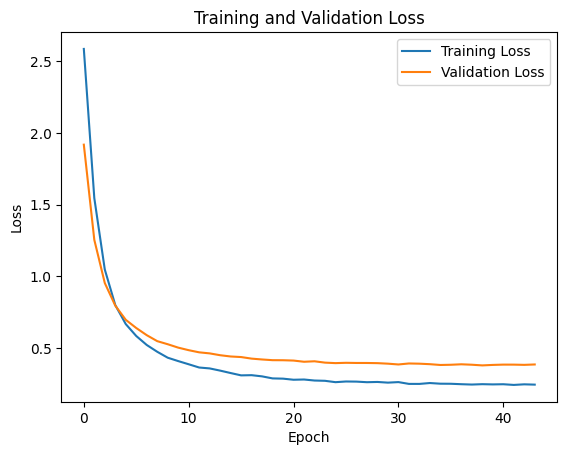

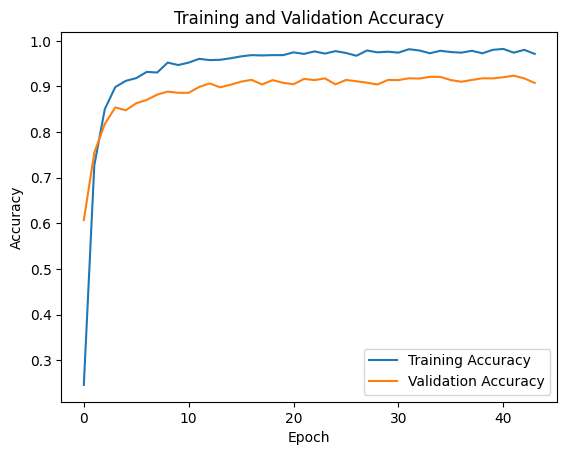

In [5]:
# Plot both training and validation losses across epochs
# plt.figure(figsize=(12, 4))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot both training and validation accuracy across epochs
# plt.figure(figsize=(12, 4))
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


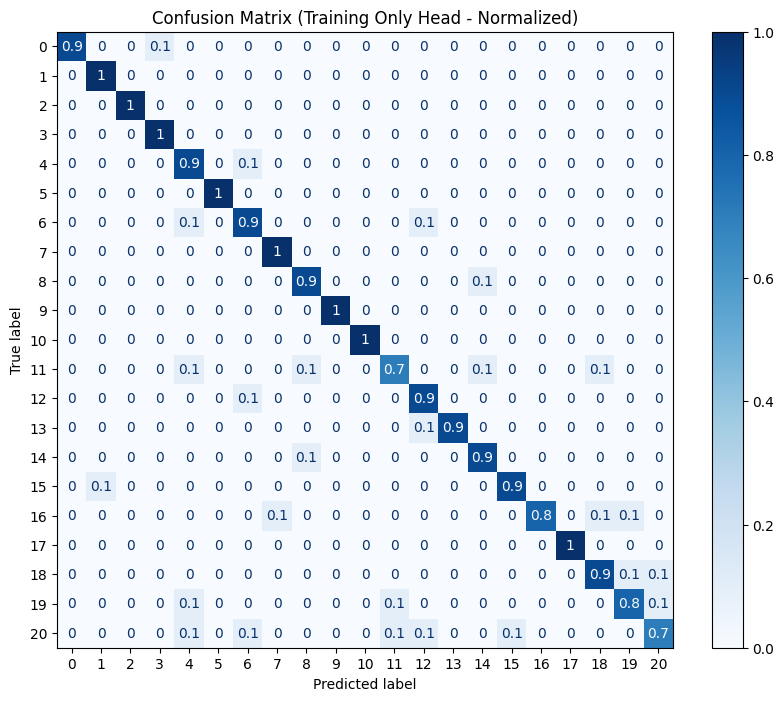

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Step 4: Evaluation

# --------------- Evaluate Model Performance on the Test Set -------------------

# Load the best model
model.load_state_dict(torch.load("best_model.pt", weights_only=True))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu())
        all_targets.append(y_batch.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

# Now compute metrics once
test_accuracy = accuracy_score(all_targets, all_preds)
test_precision = precision_score(all_targets, all_preds, average='macro')
test_recall = recall_score(all_targets, all_preds, average='macro')
test_f1 = f1_score(all_targets, all_preds, average='macro')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# ------------------ Plot Confusion Matrix for Test Data -----------------------

# Plot the confusion matrix
cm = confusion_matrix(all_targets, all_preds)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax,cmap="Blues")
plt.title("Confusion Matrix (Training Only Head)")
plt.show()

# Plot the normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.round(cm_normalized, 1)  # Round the normalized values to 1 decimal place
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(ax=ax,cmap="Blues")
plt.title("Confusion Matrix (Training Only Head - Normalized)")
plt.show()


# Problem 2.c: Fine-tuning a Pretrained Model – Retraining the Entire Network

In [8]:
# Step 1: Modify and Unfreeze the Network

# Import a ResNet18 model with ImageNet pretrained weights
model = models.resnet18(pretrained=True)

# Replace final classification head
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,num_classes)

# Make all layers trainable
for param in model.parameters():
  param.requires_grad = True

# Change runtime type to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using:", device)

# Step 2: Training Setup
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Initialize variables for early stopping
best_val_loss = float("inf")
best_epoch = -1

# keeping track of loss
val_loss_history = []
train_loss_history = []

# keeping track of accuracy
train_accuracy_history = []
val_accuracy_history = []

# For early stopping
no_improvement = 0


#-------------------------- Training loop -------------------------------------
epochs = 50
for epoch in range(epochs):
    model.train() # set model to training mode
    train_losses = [] # reset training losses
    train_accuracies = [] # reset training accuracies

    for X_batch, y_batch in train_loader:
        # send input features and reference target to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # zeroing out previous step gradients
        optimizer.zero_grad()

        # make predictions using the model
        outputs = model(X_batch)

        # calculate the loss
        loss = criterion(outputs, y_batch)

        # calculate the gradients by calling backward on the loss
        loss.backward()

        # take a step by calling step on the optimizer
        optimizer.step()

        # keep score of training loss
        train_losses.append(loss.item())

        # calculate accuracy
        preds = torch.argmax(outputs, dim=1)
        train_accuracy = accuracy_score(y_batch.cpu().numpy(), preds.detach().cpu().numpy())

        # keep score of training accuracy
        train_accuracies.append(train_accuracy)


    train_loss_mean = np.mean(train_losses) # average train loss for current epoch
    train_loss_history.append(train_loss_mean) # add to loss per epoch list

    train_accuracy_mean = np.mean(train_accuracies) # average train accuracy for current epoch
    train_accuracy_history.append(train_accuracy_mean) # add to accuracy per epoch list


    #------------------------ Validation Loop ----------------------------------
    model.eval() # set model to evaluation mode
    val_losses = [] # reset val losses
    val_accuracies = [] # reset val accuracies
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # Same as training but we are not updating weights
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            # validation loss
            val_loss = criterion(outputs, y_batch)
            val_losses.append(val_loss.item())

            # validation accuracy
            preds = torch.argmax(outputs, dim=1)
            val_accuracy = accuracy_score(y_batch.cpu().numpy(), preds.detach().cpu().numpy())
            val_accuracies.append(val_accuracy) # keep score of val accuracy

    # Implementing early stopping here.
    # Keep track of the validation loss and save the model parameters
    # when the loss is the lowest for the validation set
    val_loss_mean = np.mean(val_losses) # average val loss for current epoch
    val_loss_history.append(val_loss_mean) # add to loss per epoch list
    val_accuracy_mean = np.mean(val_accuracies) # average val accuracy for current epoch
    val_accuracy_history.append(val_accuracy_mean) # add to accuracy per epoch list
    if val_loss_mean < best_val_loss:
        best_val_loss = val_loss_mean # update the new best val loss
        best_epoch = epoch # update the best epoch
        torch.save(model.state_dict(), "best_model.pt") # save the best model params
        no_improvement = 0 # reset time since improvement
    else:
      no_improvement = no_improvement + 1
      if no_improvement >= 5: # early stop if no improvement for 5 epochs
        print(f"\nEarly stopping triggered after {best_epoch+1} epochs")
        break


    # take a step in the scheduler to update the learning rate
    scheduler.step()

    # Print summary
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {np.mean(train_losses):.4f} | Val Loss: {val_loss_mean:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

print(f"\nBest model saved from epoch {best_epoch+1} with Val Loss: {best_val_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using: cuda
Epoch 1/50 | Train Loss: 1.5337 | Val Loss: 0.5511 | LR: 0.000090
Epoch 2/50 | Train Loss: 0.2627 | Val Loss: 0.2422 | LR: 0.000081
Epoch 3/50 | Train Loss: 0.0939 | Val Loss: 0.1754 | LR: 0.000073
Epoch 4/50 | Train Loss: 0.0483 | Val Loss: 0.1463 | LR: 0.000066
Epoch 5/50 | Train Loss: 0.0325 | Val Loss: 0.1295 | LR: 0.000059
Epoch 6/50 | Train Loss: 0.0214 | Val Loss: 0.1163 | LR: 0.000053
Epoch 7/50 | Train Loss: 0.0222 | Val Loss: 0.1176 | LR: 0.000048
Epoch 8/50 | Train Loss: 0.0167 | Val Loss: 0.1074 | LR: 0.000043
Epoch 9/50 | Train Loss: 0.0136 | Val Loss: 0.1023 | LR: 0.000039
Epoch 10/50 | Train Loss: 0.0127 | Val Loss: 0.0998 | LR: 0.000035
Epoch 11/50 | Train Loss: 0.0117 | Val Loss: 0.0983 | LR: 0.000031
Epoch 12/50 | Train Loss: 0.0103 | Val Loss: 0.0938 | LR: 0.000028
Epoch 13/50 | Train Loss: 0.0096 | Val Loss: 0.0854 | LR: 0.000025
Epoch 14/50 | Train Loss: 0.0080 | Val Loss: 0.0891 | LR: 0.000023
Epoch 15/50 | Train Loss: 0.0083 | Val Loss: 0.0862 | LR: 0

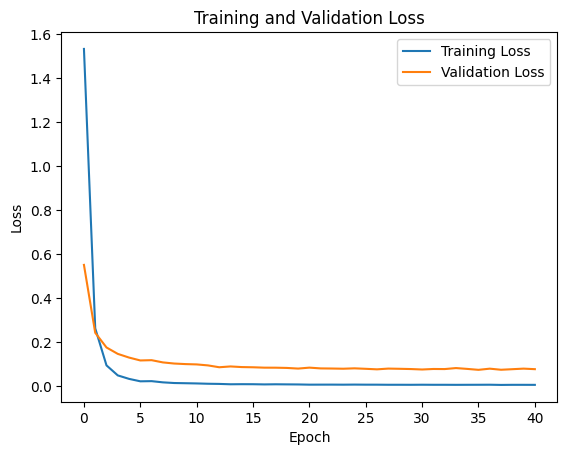

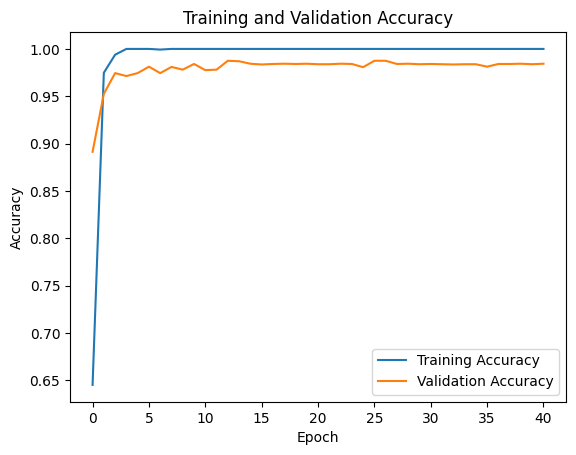

In [10]:
# Plot both training and validation losses across epochs
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot both training and validation accuracy across epochs
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Test Accuracy: 0.9683
Test Precision: 0.9705
Test Recall: 0.9683
Test F1 Score: 0.9686


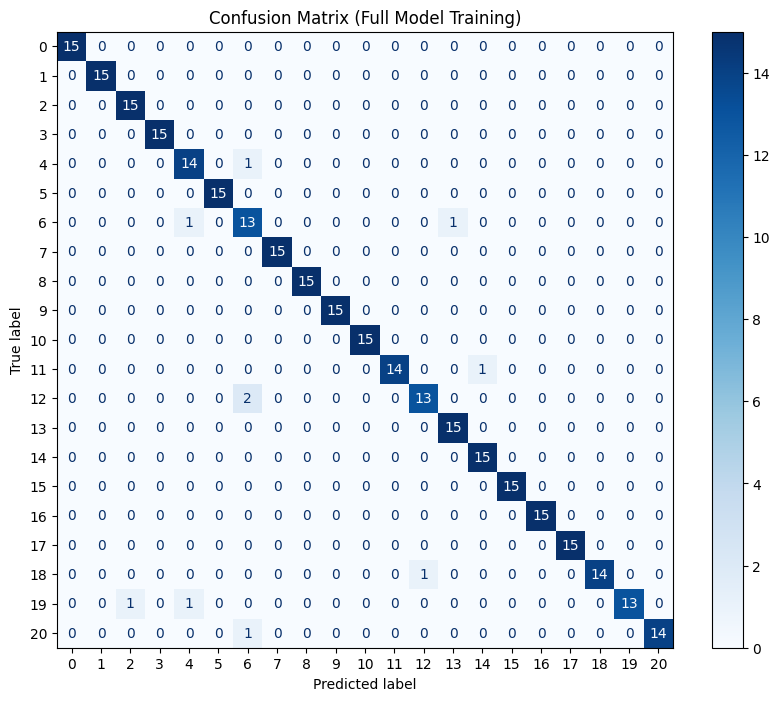

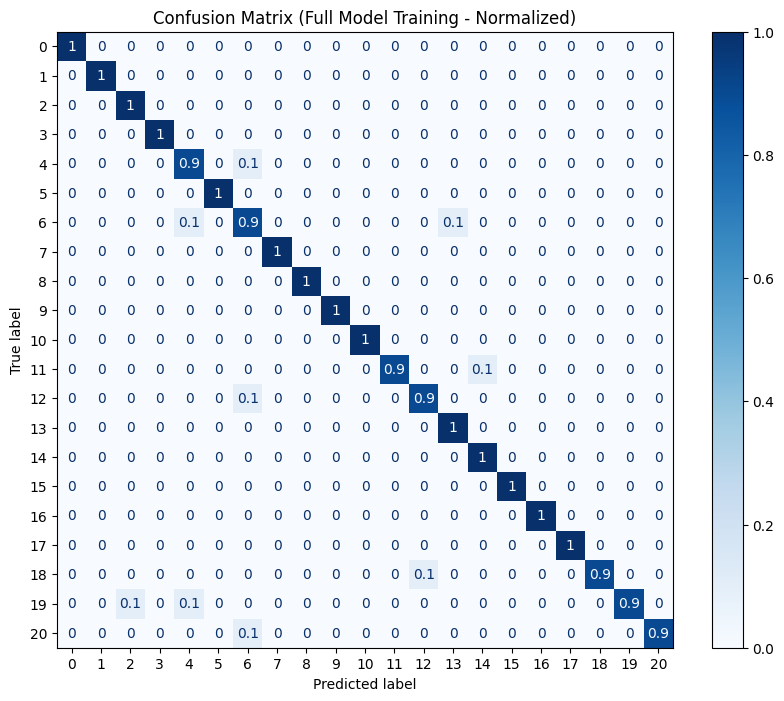

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Step 4: Evaluation

# --------------- Evaluate Model Performance on the Test Set -------------------

# Load the best model
model.load_state_dict(torch.load("best_model.pt", weights_only=True))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu())
        all_targets.append(y_batch.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

# Now compute metrics once
test_accuracy = accuracy_score(all_targets, all_preds)
test_precision = precision_score(all_targets, all_preds, average='macro')
test_recall = recall_score(all_targets, all_preds, average='macro')
test_f1 = f1_score(all_targets, all_preds, average='macro')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# ------------------ Plot Confusion Matrix for Test Data -----------------------

# Plot the confusion matrix
cm = confusion_matrix(all_targets, all_preds)
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax,cmap="Blues")
plt.title("Confusion Matrix (Full Model Training)")
plt.show()

# Plot the normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.round(cm_normalized, 1)  # Round the normalized values to 1 decimal place
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(ax=ax,cmap="Blues")
plt.title("Confusion Matrix (Full Model Training - Normalized)")
plt.show()
